In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from google.colab.patches import cv2_imshow
from google.colab import drive

In [4]:
# MOUNT GOOGLE DRIVE
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# ==========================================
# SETTINGS FOR DEXTRAN
# ==========================================
INPUT_DIR = '/content/drive/My Drive/857/Release_2000kDa_dextran/HHB_control_x10'
DEXTRAN_TYPE = "Control"
STATE = "Captrue" # or "Release"

# DETECTION: d4 (Phase Contrast) | MEASUREMENT: d1 (FITC-Dextran)
DETECTION_SUFFIX = "d4"
MEASUREMENT_SUFFIX = "d1"

# Adjust these for Phase Contrast circles (they can be fainter)
MIN_AREA = 5000
MAX_AREA = 7800   # Adjust this! If a blob is bigger than this, it's likely a cluster
CIRCULARITY_LIMIT = 0.4 # Phase contrast circles are sometimes less "perfect"
PEAK_MIN_DIST = 15 # Lowering this helps find centers of beads that are close
SHRINK_FACTOR = 0.75 # Shrink more to avoid the dark ring edge in Phase

In [20]:
def run_analysis():
    if not os.path.exists(INPUT_DIR):
        print(f"❌ 找不到路径: {INPUT_DIR}")
        return

    all_files = sorted([f for f in os.listdir(INPUT_DIR) if f.lower().endswith(f'{DETECTION_SUFFIX}.tif')])
    print(f"找到 {len(all_files)} 个文件，开始处理...")

    results = []

    for filename in all_files:
        ext = ".TIF" if filename.endswith(".TIF") else ".tif"
        detect_path = os.path.join(INPUT_DIR, filename)
        measure_path = os.path.join(INPUT_DIR, filename.replace(f"{DETECTION_SUFFIX}{ext}", f"{MEASUREMENT_SUFFIX}{ext}"))

        if not os.path.exists(measure_path):
            continue

        # 读取
        detect_img = cv2.imread(detect_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
        measure_img = cv2.imread(measure_path, cv2.IMREAD_UNCHANGED).astype(np.float32)

        # 背景计算
        kernel_bg = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (150, 150))
        bg_map = cv2.morphologyEx(measure_img, cv2.MORPH_OPEN, kernel_bg)

        # 检测
        detect_8 = cv2.normalize(detect_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(detect_8)
        thresh = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 91, 2)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=2)
        thresh = ndimage.binary_fill_holes(thresh).astype(np.uint8) * 255

        distance = ndimage.distance_transform_edt(thresh)
        local_maxi = peak_local_max(distance, min_distance=PEAK_MIN_DIST, labels=thresh)
        markers = np.zeros(distance.shape, dtype=int)
        for idx, peak in enumerate(local_maxi):
            markers[peak[0], peak[1]] = idx + 1
        labels = watershed(-distance, markers, mask=thresh)

        viz = cv2.cvtColor(detect_8, cv2.COLOR_GRAY2BGR)
        count = 0

        for label in np.unique(labels):
            if label == 0: continue
            mask_single = (labels == label).astype(np.uint8) * 255
            cnts, _ = cv2.findContours(mask_single, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not cnts: continue

            c = cnts[0]
            area = cv2.contourArea(c)
            perimeter = cv2.arcLength(c, True)
            circularity = 4 * np.pi * (area / (perimeter * perimeter)) if perimeter > 0 else 0

            if area >= MIN_AREA and area <= MAX_AREA and circularity >= CIRCULARITY_LIMIT:
                (x_d, y_d), rad_d = cv2.minEnclosingCircle(c)
                center = (int(x_d), int(y_d))
                eff_r = int(rad_d * SHRINK_FACTOR)

                core_mask = np.zeros(thresh.shape, dtype=np.uint8)
                cv2.circle(core_mask, center, eff_r, 255, -1)

                raw_val = cv2.mean(measure_img, mask=core_mask)[0]
                local_bg = cv2.mean(bg_map, mask=core_mask)[0]

                results.append({
                    'FileName': filename,
                    'Raw_FITC': raw_val,
                    'Local_Background': local_bg,
                    'Net_FITC': raw_val - local_bg,
                    'Area': area
                })

                cv2.circle(viz, center, int(rad_d), (0, 255, 0), 2)
                cv2.putText(viz, str(count), (center[0]-5, center[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)
                count += 1

        # --- 保存图片 ---
        # 建立保存路径
        save_filename = filename.replace(f"{DETECTION_SUFFIX}{ext}", "_Result.png")
        save_path = os.path.join(INPUT_DIR, save_filename)

        # 检查是否成功写入
        success = cv2.imwrite(save_path, viz)
        if success:
            print(f"📸 已保存图片: {save_filename}")
        else:
            print(f"❌ 保存失败: {save_path}")

        cv2_imshow(viz)

    # 保存 CSV
    if results:
        csv_name = f"Results_{DEXTRAN_TYPE}_{STATE}_Final.csv"
        df = pd.DataFrame(results)
        df.to_csv(os.path.join(INPUT_DIR, csv_name), index=False)
        print(f"🎉 处理完成！CSV 已保存为: {csv_name}")

run_analysis()

Output hidden; open in https://colab.research.google.com to view.

# **PLOT**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [7]:
# ==========================================
# 1. PATH CONFIGURATION
# ==========================================
# Mapping all 8 groups to their respective CSV files
data_map = [
    # Empty Groups (Baseline Controls)
    {'Beads': 'Empty', 'Enzyme': 'No', 'Time': '2h', 'Path': '/content/drive/My Drive/857/Release_2000kDa_dextran/HHB_control_x10/Results_Control_Captrue_Final.csv'},
    {'Beads': 'Empty', 'Enzyme': 'Yes', 'Time': '2h', 'Path': '/content/drive/My Drive/857/Release_2000kDa_dextran/HHB_control_lyase_x10/Results_Control_Release_Final.csv'},
    {'Beads': 'Empty', 'Enzyme': 'No', 'Time': 'Overnight', 'Path': '/content/drive/My Drive/857/Release_2000kDa_dextran/HHB_control_overnight_x10/Results_Control_Captrue_Final.csv'},
    {'Beads': 'Empty', 'Enzyme': 'Yes', 'Time': 'Overnight', 'Path': '/content/drive/My Drive/857/Release_2000kDa_dextran/HHB_control_lyase_overnight_x10/Results_Control_Release_Final.csv'},

    # Dextran Groups (Experimental)
    {'Beads': 'Dextran', 'Enzyme': 'No', 'Time': '2h', 'Path': '/content/drive/My Drive/857/Release_2000kDa_dextran/HHB_dextran_x10/Results_Dextran_2000kDa_Capture_Final.csv'},
    {'Beads': 'Dextran', 'Enzyme': 'Yes', 'Time': '2h', 'Path': '/content/drive/My Drive/857/Release_2000kDa_dextran/HHB_dextran_lyase_x10/Results_Dextran_2000kDa_Release_Final.csv'},
    {'Beads': 'Dextran', 'Enzyme': 'No', 'Time': 'Overnight', 'Path': '/content/drive/My Drive/857/Release_2000kDa_dextran/HHB_dextran_overnight_x10/Results_Dextran_2000kDa_Capture_Final.csv'},
    {'Beads': 'Dextran', 'Enzyme': 'Yes', 'Time': 'Overnight', 'Path': '/content/drive/My Drive/857/Release_2000kDa_dextran/HHB_dextran_lyase_overnight_x10/Results_Dextran_2000kDa_Release_Final.csv'},
]

all_data = []


📊 HHB SUMMARY STATISTICS (Mean ± SD)
Bead_Type      Time Enzyme        mean        std  count
  Dextran        2h     No 1083.123370 398.283111    545
  Dextran        2h    Yes  406.360853 102.490803    360
  Dextran Overnight     No  603.362885 209.546733    234
  Dextran Overnight    Yes  127.067790  17.838543    236
    Empty        2h     No   32.060544   3.454727    389
    Empty        2h    Yes   31.592262   2.697853    418
    Empty Overnight     No   29.077786   3.526080    199
    Empty Overnight    Yes   28.655868   3.119821    111


/tmp/ipython-input-2061368164.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)
/tmp/ipython-input-2061368164.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


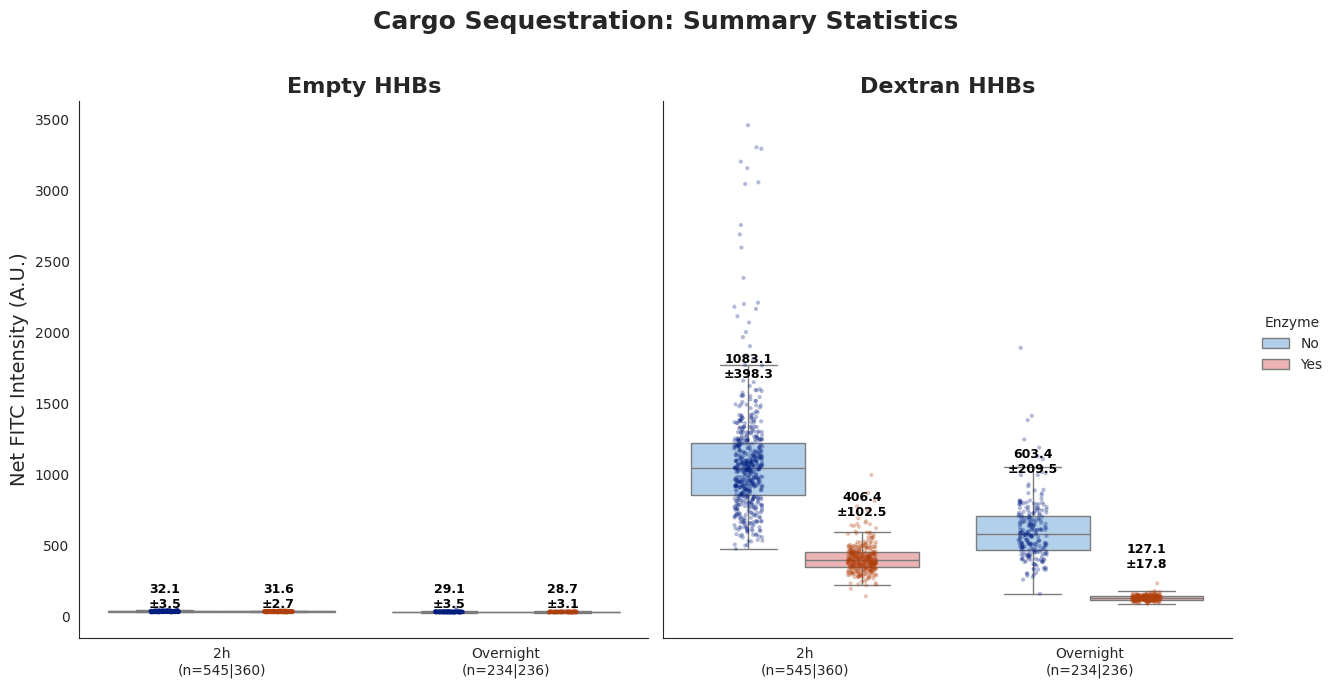

In [8]:
all_data = []
for entry in data_map:
    if os.path.exists(entry['Path']):
        df = pd.read_csv(entry['Path'])
        df['Bead_Type'] = entry['Beads']
        df['Enzyme'] = entry['Enzyme']
        df['Time'] = 'Overnight' if 'over' in entry['Time'].lower() else '2h'
        all_data.append(df)

if not all_data:
    print("❌ No data loaded. Please check file paths.")
else:
    final_df = pd.concat(all_data, ignore_index=True)

    # ==========================================
    # 2. CALCULATE STATISTICS REPORT
    # ==========================================
    # Calculate Mean, SD, and n for each group
    stats = final_df.groupby(['Bead_Type', 'Time', 'Enzyme'])['Net_FITC'].agg(['mean', 'std', 'count']).reset_index()

    # Save statistics to a CSV for your thesis table
    stats.to_csv('HHB_Summary_Statistics.csv', index=False)

    print("\n" + "="*60)
    print("📊 HHB SUMMARY STATISTICS (Mean ± SD)")
    print("="*60)
    print(stats.to_string(index=False))
    print("="*60)

    # ==========================================
    # 3. PLOTTING WITH ANNOTATIONS
    # ==========================================
    sns.set_style("white")
    time_order = ['2h', 'Overnight']

    g = sns.catplot(
        data=final_df, x='Time', y='Net_FITC', hue='Enzyme', col='Bead_Type',
        kind='box', palette={'No': '#A9D0F5', 'Yes': '#F5A9A9'},
        showfliers=False, height=7, aspect=0.9, order=time_order
    )

    g.map_dataframe(sns.stripplot, x='Time', y='Net_FITC', hue='Enzyme',
                    dodge=True, alpha=0.3, palette='dark', size=3, order=time_order)

    # --- ADD TEXT ANNOTATIONS (MEAN ± SD) TO PLOT ---
    for i, ax in enumerate(g.axes.flat):
        bead_type = ['Empty', 'Dextran'][i]
        new_labels = []

        # Get Y-axis limit to place text correctly
        y_max = final_df[final_df['Bead_Type'] == bead_type]['Net_FITC'].max()

        for idx, t in enumerate(time_order):
            for j, enzyme in enumerate(['No', 'Yes']):
                # Filter stats for this specific bar
                row = stats[(stats['Bead_Type']==bead_type) & (stats['Time']==t) & (stats['Enzyme']==enzyme)]

                if not row.empty:
                    m = row['mean'].values[0]
                    s = row['std'].values[0]
                    n = int(row['count'].values[0])

                    # Calculate X position (dodge manually)
                    # 2h is 0, Overnight is 1. 'No' is -0.2 offset, 'Yes' is +0.2 offset
                    x_pos = idx + (-0.2 if j == 0 else 0.2)

                    # Add Mean ± SD text above the box
                    ax.text(x_pos, m + s + (y_max*0.05), f"{m:.1f}\n±{s:.1f}",
                            ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

            # Update X-axis labels with n-counts
            n_no = stats[(stats['Bead_Type']==bead_type) & (stats['Time']==t) & (stats['Enzyme']=='No')]['count'].sum()
            n_yes = stats[(stats['Bead_Type']==bead_type) & (stats['Time']==t) & (stats['Enzyme']=='Yes')]['count'].sum()
            new_labels.append(f"{t}\n(n={int(n_no)}|{int(n_yes)})")

        ax.set_xticklabels(new_labels)
        ax.set_title(f"{bead_type} HHBs", fontsize=16, fontweight='bold')

    g.set_axis_labels("", "Net FITC Intensity (A.U.)", fontsize=14)
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle('Cargo Sequestration: Summary Statistics', fontsize=18, fontweight='bold')

    plt.savefig('HHB_Final_Report_with_Stats.png', dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
# ==========================================
# 1. PATH CONFIGURATION
# ==========================================
# Mapping all 8 groups to their respective CSV files
data_map = [

    # Dextran Groups (Experimental)
    {'Beads': 'Dextran', 'Enzyme': 'No', 'Time': '2h', 'Path': '/content/drive/My Drive/857/Release_2000kDa_dextran/HHB_dextran_x10/Results_Dextran_2000kDa_Capture_Final.csv'},
    {'Beads': 'Dextran', 'Enzyme': 'Yes', 'Time': '2h', 'Path': '/content/drive/My Drive/857/Release_2000kDa_dextran/HHB_dextran_lyase_x10/Results_Dextran_2000kDa_Release_Final.csv'},
]

all_data = []


📊 HHB SUMMARY STATISTICS (Mean ± SD)
Bead_Type Time Enzyme        mean        std  count
  Dextran   2h     No 1083.123370 398.283111    545
  Dextran   2h    Yes  406.360853 102.490803    360


/tmp/ipython-input-2456894121.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


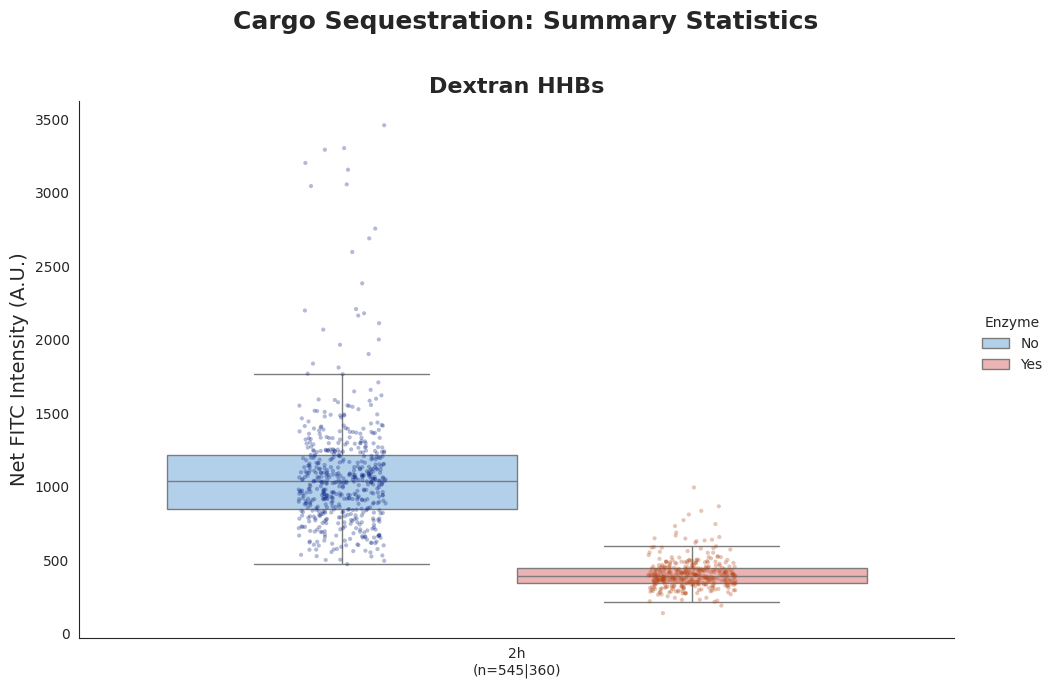

In [16]:
all_data = []
for entry in data_map:
    if os.path.exists(entry['Path']):
        df = pd.read_csv(entry['Path'])
        df['Bead_Type'] = entry['Beads']
        df['Enzyme'] = entry['Enzyme']
        df['Time'] = 'Overnight' if 'over' in entry['Time'].lower() else '2h'
        all_data.append(df)

if not all_data:
    print("❌ No data loaded. Please check file paths.")
else:
    final_df = pd.concat(all_data, ignore_index=True)

    # ==========================================
    # 2. CALCULATE STATISTICS REPORT
    # ==========================================
    # Calculate Mean, SD, and n for each group
    stats = final_df.groupby(['Bead_Type', 'Time', 'Enzyme'])['Net_FITC'].agg(['mean', 'std', 'count']).reset_index()

    # Save statistics to a CSV for your thesis table
    stats.to_csv('HHB_Summary_Statistics.csv', index=False)

    print("\n" + "="*60)
    print("📊 HHB SUMMARY STATISTICS (Mean ± SD)")
    print("="*60)
    print(stats.to_string(index=False))
    print("="*60)

    # ==========================================
    # 3. PLOTTING WITH ANNOTATIONS
    # ==========================================
    sns.set_style("white")
    time_order = ['2h']

    g = sns.catplot(
        data=final_df, x='Time', y='Net_FITC', hue='Enzyme', col='Bead_Type',
        kind='box', palette={'No': '#A9D0F5', 'Yes': '#F5A9A9'},
        showfliers=False, height=7, aspect=1.4, order=time_order
    )

    g.map_dataframe(sns.stripplot, x='Time', y='Net_FITC', hue='Enzyme',
                    dodge=True, alpha=0.3, palette='dark', size=3, order=time_order)

    # --- ADD TEXT ANNOTATIONS (MEAN ± SD) TO PLOT ---
    for i, ax in enumerate(g.axes.flat):
        bead_type = ['Dextran'][i]
        new_labels = []

        # Get Y-axis limit to place text correctly
        y_max = final_df[final_df['Bead_Type'] == bead_type]['Net_FITC'].max()

        for idx, t in enumerate(time_order):
            for j, enzyme in enumerate(['No', 'Yes']):
                # Filter stats for this specific bar
                row = stats[(stats['Bead_Type']==bead_type) & (stats['Time']==t) & (stats['Enzyme']==enzyme)]

                if not row.empty:
                    m = row['mean'].values[0]
                    s = row['std'].values[0]
                    n = int(row['count'].values[0])

                    # Calculate X position (dodge manually)
                    # 2h is 0, Overnight is 1. 'No' is -0.2 offset, 'Yes' is +0.2 offset
                    x_pos = idx + (-0.2 if j == 0 else 0.2)

                    # Add Mean ± SD text above the box
                    # ax.text(x_pos, m + s + (y_max*0.05), f"{m:.1f}\n±{s:.1f}",
                    #         ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

            # Update X-axis labels with n-counts
            n_no = stats[(stats['Bead_Type']==bead_type) & (stats['Time']==t) & (stats['Enzyme']=='No')]['count'].sum()
            n_yes = stats[(stats['Bead_Type']==bead_type) & (stats['Time']==t) & (stats['Enzyme']=='Yes')]['count'].sum()
            new_labels.append(f"{t}\n(n={int(n_no)}|{int(n_yes)})")

        ax.set_xticklabels(new_labels)
        ax.set_title(f"{bead_type} HHBs", fontsize=16, fontweight='bold')

    g.set_axis_labels("", "Net FITC Intensity (A.U.)", fontsize=14)
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle('Cargo Sequestration: Summary Statistics', fontsize=18, fontweight='bold')

    plt.savefig('HHB_Final_Report_with_Stats.png', dpi=300, bbox_inches='tight')
    plt.show()